In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkb
import h3
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import transform
import shapely.wkb as swkb
from functools import partial
import pyproj
import matplotlib.pyplot as plt
import rtree
import osmnx as ox
from shapely.ops import unary_union

import warnings
warnings.filterwarnings('ignore') 



In [2]:
amsterdam = pd.read_parquet("amsterdam_bike_paths_extended.parquet")
cracow = pd.read_parquet("krakow_bike_paths_extended.parquet")

In [3]:
def extract_features(series):
    dict_of_lists = {}
    for d in series:
        for key, value in d.items():
            dict_of_lists.setdefault(key, []).append(value)
            
    return pd.DataFrame(data=dict_of_lists)

def create_gdf(df):
    df['geometry'] = df['geometry'].apply(lambda x: swkb.loads(x, hex = True))
    gdf = gpd.GeoDataFrame(data=df, geometry='geometry')
    gdf = gdf.set_crs('EPSG:4326')
    return gdf
gdf_ams = create_gdf(amsterdam)
gdf_krk = create_gdf(cracow)
gdf_ams

,id,tags,geometry
0,4264947,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.92236 52.36544, 4.92237 52.36543..."
1,4270806,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.93089 52.36596, 4.93090 52.36585..."
2,4305753,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.86787 52.32198, 4.86787 52.32192)"
3,4363637,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.91538 52.37115, 4.91544 52.37118..."
4,4364612,"{'abandoned:railway': None, 'access': 'yes', '...","LINESTRING (4.92291 52.37384, 4.92291 52.37389..."
...,...,...,...
8613,1279692697,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96860 52.37958, 4.96858 52.37956..."
8614,1279692698,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96840 52.37969, 4.96838 52.37968..."
8615,1279692703,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96858 52.37983, 4.96845 52.37992..."
8616,1279692704,"{'abandoned:railway': None, 'access': None, 'a...","LINESTRING (4.96882 52.37971, 4.96858 52.37983)"


Text(492.9494949494949, 0.5, 'Szerokość geograficzna')

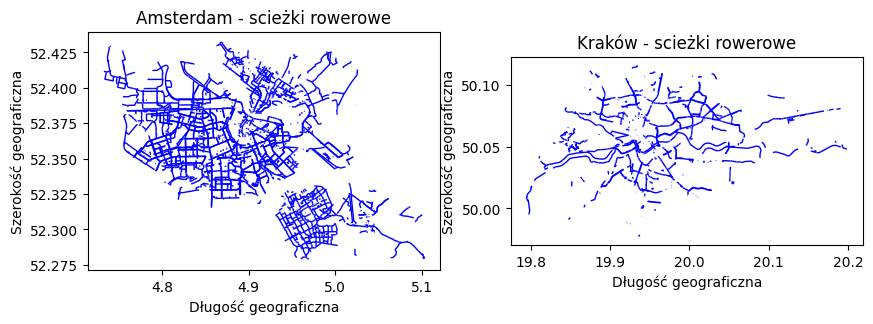

In [4]:
fig, axes = plt.subplots(1,2, figsize = [10, 10])
gdf_ams.plot(ax = axes[0], linewidth = 1, edgecolor = 'blue')

axes[0].set_title('Amsterdam - scieżki rowerowe')
axes[0].set_xlabel('Długość geograficzna')
axes[0].set_ylabel('Szerokość geograficzna')

gdf_krk.plot(ax = axes[1], linewidth = 1, edgecolor = 'blue')

axes[1].set_title('Kraków - scieżki rowerowe')
axes[1].set_xlabel('Długość geograficzna')
axes[1].set_ylabel('Szerokość geograficzna')

In [5]:
# Generowanie heksagonów H3 na obszarze Amsterdamu
def create_h3_hex_grid(df,bounds,epsg=4326):
    resolution = 8  # Rezolucja H3, im wyższa liczba, tym mniejsze heksagony
    buffer = 0.01
    h3_indices = h3.polyfill(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [bounds["west"], bounds["north"]],
                    [bounds["east"], bounds["north"]],
                    [bounds["east"], bounds["south"]],
                    [bounds["west"], bounds["south"]],
                    [bounds["west"], bounds["north"]],
                ]
            ],
        },
        resolution,
    )
    
    # Konwersja H3 do GeoDataFrame
    hexagons = []
    for h in h3_indices:
        hex_boundary = h3.h3_to_geo_boundary(h, geo_json=True)
        hex_boundary = [(lng, lat) for lat, lng in hex_boundary]
        hex_boundary.append(hex_boundary[0])  # Zamknięcie obwodu heksagonu
        hexagons.append({
            'geometry': Polygon(hex_boundary),
            'h3_index': h
        })
    
    gdf_hex = gpd.GeoDataFrame(hexagons)
    gdf_hex = gdf_hex.set_crs(epsg=epsg)
    
    return gdf_hex
 
# Funkcja przypisująca ścieżki rowerowe do heksagonów
def assign_hexagon(geometry, resolution):
    centroid = geometry.centroid
    return h3.geo_to_h3(centroid.y, centroid.x, resolution)



## Siatka hex z mapą

In [6]:
#Współrzędne granic Amsterdamu i Krakowa
amsterdam_bounds = {"north": 52.441157,"south": 52.2688,"east": 5.1127658,"west": 4.728073}
cracow_bounds = {"north":50.1257,"south":49.9639,"east": 20.215,"west":19.7946}

gdf_ams['h3_index'] = gdf_ams['geometry'].apply(assign_hexagon, resolution=8)
gdf_krk['h3_index'] = gdf_krk['geometry'].apply(assign_hexagon, resolution=8)


gdf_krk_hex = create_h3_hex_grid(gdf_krk,cracow_bounds)    
gdf_ams_hex = create_h3_hex_grid(gdf_ams,amsterdam_bounds)    

amsterdam_area = ox.geocode_to_gdf('Amsterdam, Netherlands')
cracow_area = ox.geocode_to_gdf('Kraków')




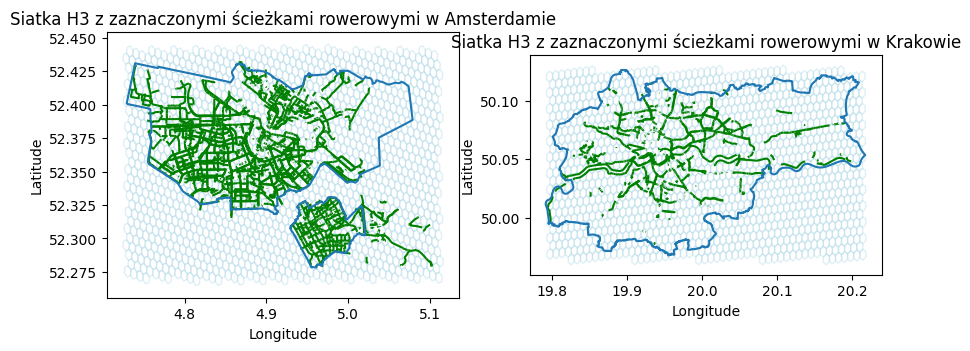

In [7]:
# Wizualizacja
fig, ax = plt.subplots(1,2,figsize=(10, 10))
gdf_ams_hex.plot(ax=ax[0], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_ams.plot(ax=ax[0], color='green')
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
ax[0].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Amsterdamie')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk_hex.plot(ax=ax[1], facecolor='none', edgecolor='lightblue',alpha=0.4)
gdf_krk.plot(ax=ax[1], color='green')
cracow_area['geometry'].boundary.plot(ax=ax[1])

ax[1].set_title('Siatka H3 z zaznaczonymi ścieżkami rowerowymi w Krakowie')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

## Przycięcie map i heksagonów

In [8]:

def crop_hex_grid(gdf_hex,gdf_bike,gdf_area,epsg):
    gdf_bike = gdf_bike.to_crs(epsg=epsg)
    gdf_hex = gdf_hex.to_crs(epsg=epsg)
    gdf_area = gdf_area.to_crs(epsg=epsg)
    gdf_hex['bike_path_length'] = 0.0
    gdf_hex['within_city'] = False

    for i, polygon in gdf_hex.iterrows():
        clipped = gdf_bike.clip(polygon.geometry)
        within_city = polygon.geometry.intersects(gdf_area.geometry)
        gdf_hex.loc[i,'bike_path_length'] = clipped.length.sum()
        gdf_hex.loc[i,'within_city'] = within_city[0]

    gdf_hex = gdf_hex[(gdf_hex['within_city'] == True) | (gdf_hex['bike_path_length'] > 0)]
    gdf_hex = gdf_hex.to_crs(epsg=4326)
    del gdf_hex['within_city']
    
    return gdf_hex

gdf_ams_hex = crop_hex_grid(gdf_ams_hex, gdf_ams, amsterdam_area, 2180)
gdf_krk_hex = crop_hex_grid(gdf_krk_hex, gdf_krk, cracow_area, 2180)


Text(492.9494949494949, 0.5, 'Latitude')

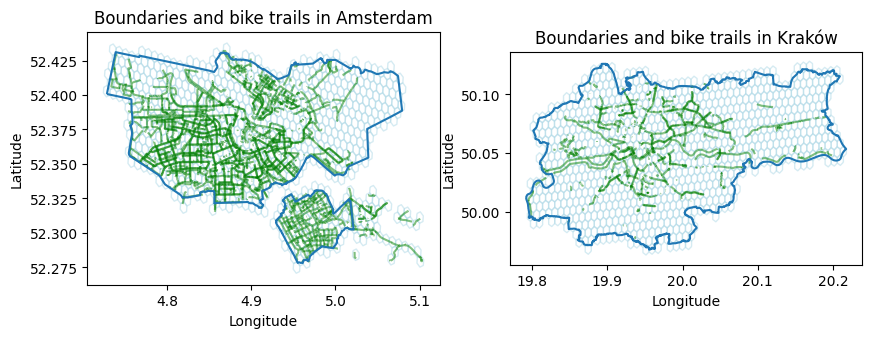

In [9]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
gdf_ams.plot(ax=ax[0], edgecolor='green', facecolor='none', alpha=0.5)
gdf_ams_hex.plot(ax=ax[0], edgecolor='lightblue', facecolor='none', alpha=0.5)
amsterdam_area['geometry'].boundary.plot(ax=ax[0])
# Set plot title and labels
ax[0].set_title('Boundaries and bike trails in Amsterdam')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

gdf_krk.plot(ax=ax[1], edgecolor='green', facecolor='none', alpha=0.5)
gdf_krk_hex.plot(ax=ax[1], edgecolor='lightblue', facecolor='none', alpha=0.5)
cracow_area['geometry'].boundary.plot(ax=ax[1])
# Set plot title and labels
ax[1].set_title('Boundaries and bike trails in Kraków')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

## Hex razem z policzoną długością ścieżki rowerowej

In [10]:
gdf_ams_hex

,geometry,h3_index,bike_path_length
0,"POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...",887ab646cbfffff,702.617398
4,"POLYGON ((4.95049 52.38571, 4.95447 52.38691, ...",887ab6094dfffff,167.517418
6,"POLYGON ((4.94822 52.32916, 4.95220 52.33036, ...",887ab60807fffff,1051.507050
10,"POLYGON ((4.99824 52.40010, 5.00222 52.40130, ...",887ab6460bfffff,539.811959
12,"POLYGON ((4.80525 52.36193, 4.80924 52.36313, ...",887ab61ab5fffff,3204.988301
...,...,...,...
1381,"POLYGON ((4.79463 52.37071, 4.79862 52.37191, ...",887ab61aabfffff,1689.939959
1383,"POLYGON ((5.04903 52.29970, 5.05301 52.30090, ...",887ab67303fffff,640.341685
1387,"POLYGON ((4.88456 52.38181, 4.88854 52.38301, ...",887ab619b1fffff,68.605091
1388,"POLYGON ((4.97696 52.30988, 4.98094 52.31108, ...",887ab609d1fffff,2198.261947


In [ ]:
gdf_krk_hex

## Pozostałe argumenty - odległość od dróg głównych i chodników

In [14]:
def calculate_road_lengths(amsterdam_bounds, gdf_ams_hex,hex_area):
    # Get road and walk networks
    Ams_roads = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='drive')
    Ams_walks = ox.graph_from_bbox(bbox=(amsterdam_bounds['north'],
                                         amsterdam_bounds['south'],
                                         amsterdam_bounds['east'],
                                         amsterdam_bounds['west']), 
                                   network_type='walk')

    # Convert the road network to a GeoDataFrame of edges
    ams_roads = ox.graph_to_gdfs(Ams_roads, nodes=False)
    ams_walks = ox.graph_to_gdfs(Ams_walks, nodes=False)

    # Filter main roads
    ams_roads['highway'] = ams_roads['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)
    main_road_types = ['secondary', 'primary', 'tertiary', 'busway', 'motorway_link', 'motorway']
    ams_roads_main = ams_roads[ams_roads['highway'].isin(main_road_types)]

    # Clip to the hexagonal area
    # hex_area = unary_union(gdf_ams_hex.geometry)
    ams_roads_main_clipped = ams_roads_main.geometry.clip(hex_area)
    ams_walks_clipped = ams_walks.geometry.clip(hex_area)

    # Project to the appropriate CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=28992)
    ams_roads_main_clipped_proj = ams_roads_main_clipped.to_crs(epsg=28992)
    ams_walks_clipped_proj = ams_walks_clipped.to_crs(epsg=28992)

    # Initialize length columns
    gdf_ams_hex['main_roads_length'] = 0.0
    gdf_ams_hex['walks_length'] = 0.0

    # Calculate lengths for each hexagon
    for i, polygon in gdf_ams_hex.iterrows():
        clipped_r = ams_roads_main_clipped_proj.clip(polygon.geometry)
        clipped_w = ams_walks_clipped_proj.clip(polygon.geometry)
        gdf_ams_hex.at[i, 'main_roads_length'] = clipped_r.length.sum()
        gdf_ams_hex.at[i, 'walks_length'] = clipped_w.length.sum()

    # Reproject back to the original CRS
    gdf_ams_hex = gdf_ams_hex.to_crs(epsg=4326)

    return gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped
    


In [15]:
hex_area_ams = unary_union(gdf_ams_hex.geometry)
gdf_ams_hex,ams_walks_clipped,ams_roads_main_clipped = calculate_road_lengths(amsterdam_bounds,gdf_ams_hex, hex_area_ams)
gdf_ams_hex

,geometry,h3_index,bike_path_length,main_roads_length,walks_length
0,"POLYGON ((5.00176 52.36127, 5.00574 52.36247, ...",887ab646cbfffff,702.617398,619.057031,722.519073
4,"POLYGON ((4.95049 52.38571, 4.95447 52.38691, ...",887ab6094dfffff,167.517418,73.248243,2876.329549
6,"POLYGON ((4.94822 52.32916, 4.95220 52.33036, ...",887ab60807fffff,1051.507050,932.737259,14498.301281
10,"POLYGON ((4.99824 52.40010, 5.00222 52.40130, ...",887ab6460bfffff,539.811959,0.000000,1273.936163
12,"POLYGON ((4.80525 52.36193, 4.80924 52.36313, ...",887ab61ab5fffff,3204.988301,4063.529285,31183.105926
...,...,...,...,...,...
1381,"POLYGON ((4.79463 52.37071, 4.79862 52.37191, ...",887ab61aabfffff,1689.939959,1759.500038,12874.328103
1383,"POLYGON ((5.04903 52.29970, 5.05301 52.30090, ...",887ab67303fffff,640.341685,1246.962410,4221.868264
1387,"POLYGON ((4.88456 52.38181, 4.88854 52.38301, ...",887ab619b1fffff,68.605091,129.055829,18633.360699
1388,"POLYGON ((4.97696 52.30988, 4.98094 52.31108, ...",887ab609d1fffff,2198.261947,694.189734,17755.881667


Text(61.597222222222214, 0.5, 'Latitude')

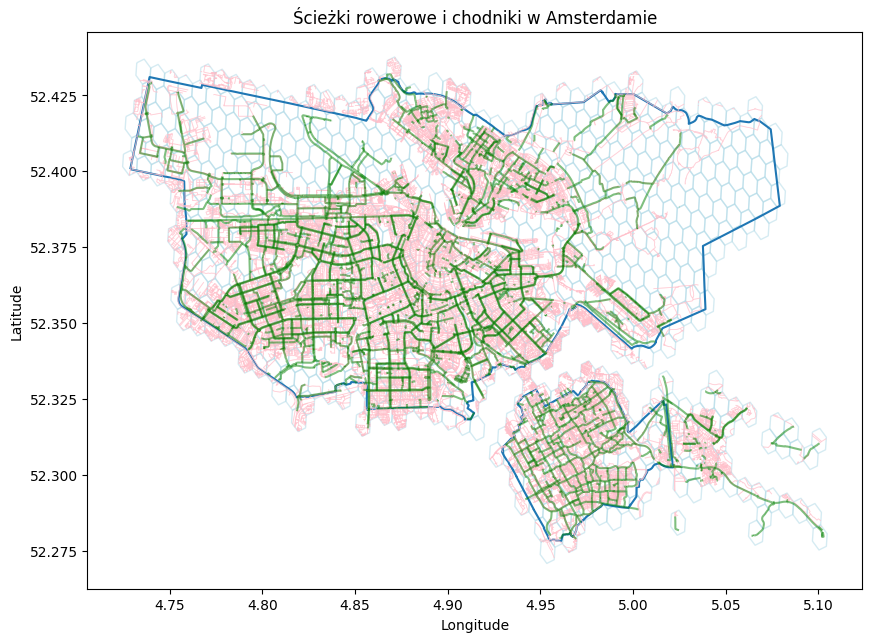

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
amsterdam_area['geometry'].boundary.plot(ax=ax)
ams_walks_clipped.plot(ax=ax, edgecolor='pink', facecolor='none', alpha=0.5,linewidth = 0.6)
gdf_ams_hex.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
gdf_ams.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5)

ax.set_title('Ścieżki rowerowe i chodniki w Amsterdamie')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [17]:
hex_area_krk = unary_union(gdf_krk_hex.geometry)
gdf_krk_hex,krk_walks_clipped,krk_roads_main_clipped = calculate_road_lengths(cracow_bounds,gdf_krk_hex, hex_area_krk)
gdf_krk_hex

,geometry,h3_index,bike_path_length,main_roads_length,walks_length
2,"POLYGON ((20.19345 50.04742, 20.18943 50.04479...",8852666de7fffff,721.574271,0.000000,4350.686133
5,"POLYGON ((19.97908 50.09187, 19.97506 50.08923...",885262c723fffff,2100.218565,1830.709404,51194.966852
7,"POLYGON ((19.90248 50.07863, 19.89846 50.07600...",885262cec5fffff,210.742447,1610.327137,31002.455124
8,"POLYGON ((20.03972 50.07619, 20.03570 50.07355...",885262c2d3fffff,695.019118,2657.168772,60055.015365
9,"POLYGON ((20.00320 50.10766, 19.99918 50.10503...",885262c70bfffff,0.000000,1363.611168,7728.601663
...,...,...,...,...,...
1211,"POLYGON ((20.09206 50.10123, 20.08804 50.09860...",885262d423fffff,0.000000,0.000000,3754.479210
1212,"POLYGON ((20.08408 50.08676, 20.08006 50.08413...",885262d51bfffff,0.000000,63.349620,9273.863965
1213,"POLYGON ((19.85010 50.06741, 19.84608 50.06478...",885262cc13fffff,14.042876,3031.094950,11391.665421
1214,"POLYGON ((19.90295 49.98210, 19.89892 49.97948...",885262cf45fffff,0.000000,1253.659314,12023.987879


Text(61.347222222222214, 0.5, 'Latitude')

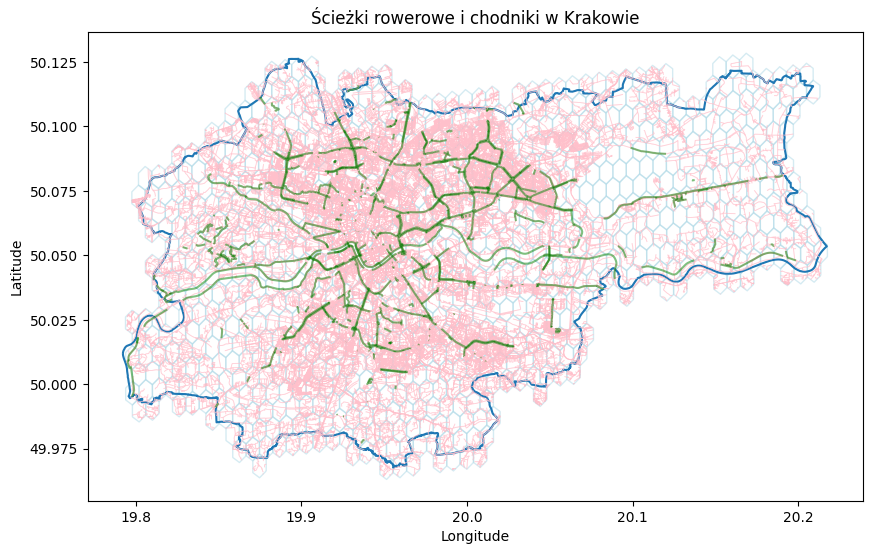

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
cracow_area['geometry'].boundary.plot(ax=ax)
krk_walks_clipped.plot(ax=ax, edgecolor='pink', facecolor='none', alpha=0.5,linewidth = 0.6)
gdf_krk_hex.plot(ax=ax, edgecolor='lightblue', facecolor='none', alpha=0.5)
gdf_krk.plot(ax=ax, edgecolor='green', facecolor='none', alpha=0.5)

ax.set_title('Ścieżki rowerowe i chodniki w Krakowie')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')